<a href="https://colab.research.google.com/github/PaulToronto/Stanford-Andrew-Ng-Machine-Learning-Specialization/blob/main/2_1_3_1_Lab_Coffee_Roasting_in_TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab - Coffee Roasting in TensorFlow

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors as colors

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

## Functions

In [2]:
def sigmoid(z):
    """
    Compute the sigmoid of z

    Parameters
    ----------
    z : array_like
        A scalar or numpy array of any size.

    Returns
    -------
     g : array_like
         sigmoid(z)
    """
    z = np.clip( z, -500, 500 )           # protect against overflow
    g = 1.0/(1.0+np.exp(-z))

    return g

## Dataset

In [3]:
path = 'https://raw.githubusercontent.com/PaulToronto/'
path += 'Stanford-Andrew-Ng-Machine-Learning-Specialization/main/data/'
path += 'coffee.csv'

coffee = pd.read_csv(path)
coffee

,Temperature,Duration,Quality
0,185.32,12.69,1.0
1,259.92,11.87,0.0
2,231.01,14.41,0.0
3,175.37,11.72,0.0
4,187.12,14.13,1.0
...,...,...,...
195,223.78,15.30,0.0
196,266.63,12.48,0.0
197,273.68,13.10,0.0
198,220.61,12.80,1.0


In [4]:
X = coffee.drop('Quality', axis=1).values
Y = coffee[['Quality']].values
X.shape, Y.shape

((200, 2), (200, 1))

## Plot Coffee Roasting Data

The two features are Temperature in Celsius and Duration in minutes. 'Coffee Roasting at Home' suggests that the duration is best kept between 12 and 15 minutes while the temp should be between 175 and 260 degrees Celsius. Of course, as temperature rises, the duration should shrink.

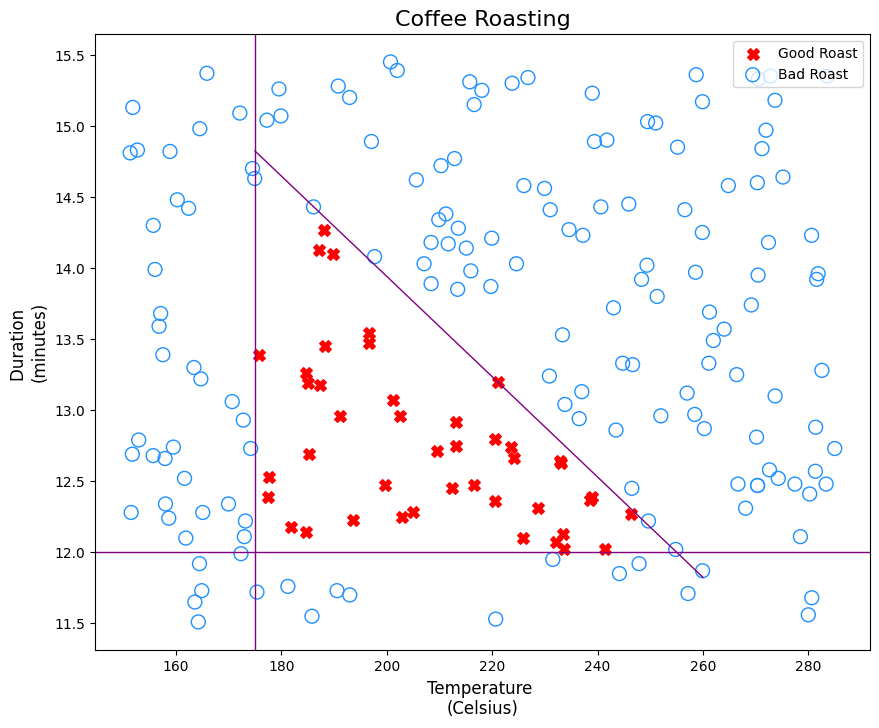

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

y = Y.reshape(-1, )

ax.scatter(X[y==1, 0], X[y==1, 1], s=70, marker='X', c='r', label='Good Roast')
ax.scatter(X[y==0, 0], X[y==0, 1], s=100, marker='o', facecolor='none',
           edgecolors='dodgerblue', linewidth=1, label='Bad Roast')
ax.axhline(y=12, color='purple', linewidth=1)
ax.axvline(x=175, color='purple', linewidth=1)
tr = np.linspace(175, 260, 50)
ax.plot(tr, (-3/85) * tr + 21, color='purple', linewidth=1)

ax.set_title('Coffee Roasting', size=16)
ax.set_xlabel("Temperature \n(Celsius)",size=12)
ax.set_ylabel("Duration \n(minutes)",size=12)
ax.legend(loc='upper right')

plt.show()

## Normalize Data

- Fitting the weights to the data (back-propagation) proceeds more quickly when the data is normalize3
- This procedure uses the Keras [normalization layer](https://keras.io/api/layers/preprocessing_layers/numerical/normalization/)
- Steps
 1. Create a "Normalization Layer": this is not a layer in your model
 2. `adapt` the data (learns the mean and variance of the dataset and stores the values internally
 2. normalize the data

### Normalization done manually

In [6]:
temp = X[:, 0]
duration = X[:, 1]

In [7]:
np.min(temp), np.max(temp)

(151.32, 284.99)

In [8]:
np.min(duration), np.max(duration)

(11.51, 15.45)

In [9]:
mean_temp = np.mean(temp)
sd_temp = np.std(temp)
mean_dur = np.mean(duration)
sd_dur = np.std(duration)

In [10]:
temp_normalized = (temp - mean_temp) / sd_temp
np.min(temp_normalized), np.max(temp_normalized)

(-1.6853088788798358, 1.6596592021902514)

In [11]:
dur_normalized = (duration - mean_dur) / sd_dur
np.min(dur_normalized), np.max(dur_normalized)

(-1.702106854469827, 1.7897579793596083)

### Normalization using TensorFlow

In [12]:
norm_layer = tf.keras.layers.Normalization(axis=-1)
norm_layer

In [13]:
norm_layer.adapt(X)
Xn = norm_layer(X)

In [14]:
# min and max temperature
np.min(Xn[:, 0]), np.max(Xn[:, 0])

(-1.6853083, 1.6596596)

In [15]:
# min and max duration
np.min(Xn[:, 1]), np.max(Xn[:, 1])

(-1.7021072, 1.7897574)

## Tile Data

In [16]:
# tile/copy data to increase the training set size and
#  reduce the number of epochs
Xt = np.tile(Xn, (1000, 1))
Yt = np.tile(Y, (1000, 1))

In [17]:
X.shape, Xn.shape, Xt.shape

((200, 2), TensorShape([200, 2]), (200000, 2))

In [18]:
Y.shape, Yt.shape

((200, 1), (200000, 1))

## TensorFlow Model

<img src='https://drive.google.com/uc?export=view&id=1pNscrM4uMbFa1Lvhqv6YyNC-Ivy2i5hh'>

In [19]:
tf.random.set_seed(1234)

model = Sequential([
    tf.keras.Input(shape=(2, )),
    Dense(3, activation='sigmoid', name='layer1'),
    Dense(1, activation='sigmoid', name='layer2')
])

>**Note 1:** The `tf.keras.Input(shape=(2,)),` specifies the expected shape of the input. This allows Tensorflow to size the weights and bias parameters at this point.  This is useful when exploring Tensorflow models. This statement can be omitted in practice and Tensorflow will size the network parameters when the input data is specified in the `model.fit` statement.  
>**Note 2:** Including the sigmoid activation in the final layer is not considered best practice. It would instead be accounted for in the loss which improves numerical stability. This will be described in more detail in a later lab.

The `model.summary()` provides a description of the network:

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, 3)                 9         
                                                                 
 layer2 (Dense)              (None, 1)                 4         
                                                                 
Total params: 13 (52.00 Byte)
Trainable params: 13 (52.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [21]:
layer1 = model.get_layer('layer1')
layer2 = model.get_layer('layer2')

In [22]:
# number of variables in input * number nodes + number nodes
L1_num_params = layer1.input.shape[1] * layer1.units + layer1.units # W1 parameters + b_parameters
L2_num_params = layer2.input.shape[1] * layer2.units + layer2.units
L1_num_params, L2_num_params

(9, 4)

### Initial Weights

In [23]:
W1, b1 = layer1.get_weights()
W1, b1

(array([[ 0.5558704 , -0.3223917 , -0.4835118 ],
        [-0.6621217 , -0.53733146,  0.06389952]], dtype=float32),
 array([0., 0., 0.], dtype=float32))

In [24]:
W2, b2 = layer2.get_weights()
W2, b2

(array([[ 0.89618576],
        [-0.8545872 ],
        [ 0.3281994 ]], dtype=float32),
 array([0.], dtype=float32))

### Compile and Fit

The following statements will be described in detail in Week2. For now:
- The `model.compile` statement defines a loss function and specifies a compile optimization.
- The `model.fit` statement runs gradient descent and fits the weights to the data.

In [25]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01),
    loss = tf.keras.losses.BinaryCrossentropy()
)

In [26]:
model.fit(Xt, Yt, epochs=10)

Epoch 1/10
6250/6250 [==============================] - 20s 3ms/step - loss: 0.1838
Epoch 2/10
6250/6250 [==============================] - 11s 2ms/step - loss: 0.1266
Epoch 3/10
6250/6250 [==============================] - 11s 2ms/step - loss: 0.1051
Epoch 4/10
6250/6250 [==============================] - 11s 2ms/step - loss: 0.0275
Epoch 5/10
6250/6250 [==============================] - 11s 2ms/step - loss: 0.0148
Epoch 6/10
6250/6250 [==============================] - 10s 2ms/step - loss: 0.0099
Epoch 7/10
6250/6250 [==============================] - 12s 2ms/step - loss: 0.0070
Epoch 8/10
6250/6250 [==============================] - 11s 2ms/step - loss: 0.0050
Epoch 9/10
6250/6250 [==============================] - 11s 2ms/step - loss: 0.0036
Epoch 10/10
6250/6250 [==============================] - 11s 2ms/step - loss: 0.0027


### Epochs and batches

- In the `compile` statement, the number of **epochs** was set to 10. This specifies that the entire data should be applied during training 10 times
- For efficiency, the training dataset is broken into **batches**. In TensorFlow, the default batch size is 32
- There are 200000 examples in our expanded dataset, so there are 6250 batches

In [27]:
200_000 / 32

6250.0

### Updated Weights

In [28]:
W1, b1 = layer1.get_weights()
W1, b1

(array([[-1.7463940e+01,  4.2496552e-03, -1.0702339e+01],
        [-1.4600339e+01, -8.4924965e+00, -2.5961140e-01]], dtype=float32),
 array([ -2.5732396, -10.62283  , -11.66325  ], dtype=float32))

In [29]:
W2, b2 = layer2.get_weights()
W2, b2

(array([[ 34.277275],
        [-43.019096],
        [-48.102776]], dtype=float32),
 array([-9.16911], dtype=float32))

### Predictions

In [30]:
X_test = np.array([
    [200,13.9],  # postive example
    [200,17]])   # negative example

In [31]:
X_test_norm = norm_layer(X_test)
X_test_norm

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[-0.46713647,  0.41605395],
       [-0.46713647,  3.1634607 ]], dtype=float32)>

In [32]:
predictions = model.predict(X_test_norm)
predictions

1/1 [==============================] - 0s 85ms/step


array([[9.7811341e-01],
       [1.0142391e-04]], dtype=float32)

In [33]:
# apply threshold
y_hat = (predictions >= 0.5).astype(int)
y_hat

array([[1],
       [0]])

### Manual Predictions

In [34]:
l1 = sigmoid(X_test_norm @ W1 + b1)
l2 = sigmoid(l1 @ W2 + b2)
l2 # same as `predictions` above

array([[9.7811335e-01],
       [1.0142391e-04]], dtype=float32)

## Layer Functions

In [35]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    """ truncates color map """
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

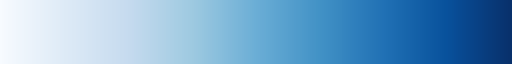

In [36]:
cmap = plt.get_cmap('Blues')
cmap

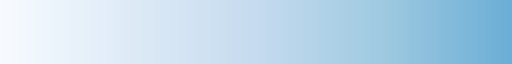

In [37]:
truncate_colormap(cmap, 0.0, 0.5)

In [38]:
# this just shows that my sigmoid function works like the sigmoid function in keras
(
    tf.keras.activations.sigmoid(tf.constant([3], dtype = tf.float32)).numpy(),
    sigmoid(3)
)

(array([0.95257413], dtype=float32), 0.9525741268224334)

### Visualize Layer 1

In [39]:
def plt_prob(ax, fwb):
    """ plots a decision boundary but include shading to indicate the probability """
    x0_space = np.linspace(150, 285, 40)
    x1_space = np.linspace(11.5, 15.5, 40)

    # get probability for X0, X1 ranges
    tmp_X0, tmp_X1 = np.meshgrid(x0_space, x1_space)
    z = np.zeros_like(tmp_X0)
    for i in range(z.shape[0]):
        for j in range(z.shape[1]):
            x = np.array([[tmp_X0[i, j], tmp_X1[i, j]]])
            z[i, j] = fwb(x)

    cmap = plt.get_cmap('Blues')
    new_cmap = truncate_colormap(cmap, 0.0, 0.5)
    pcm = ax.pcolormesh(tmp_X0, tmp_X1, z, cmap=new_cmap,
                        norm=cm.colors.Normalize(vmin=0, vmax=1),
                        shading='nearest', alpha=0.9)
    ax.figure.colorbar(pcm, ax=ax)

In [40]:
def plt_layer(X, Y, W1, b1, norm_layer):
    y = Y.reshape(-1,)

    fig, ax = plt.subplots(1, W1.shape[1], figsize=(16, 4))

    for i in range(W1.shape[1]):
        #layerf = lambda x: sigmoid(np.dot(norm_layer(x), W1[:, i]) + b1[i])
        layerf = lambda x: tf.keras.activations.sigmoid(np.dot(norm_layer(x), W1[:, i]) + b1[i])
        plt_prob(ax[i], layerf)
        ax[i].scatter(X[y==1, 0], X[y==1, 1],
                      s=70, marker='X', c='r')
        ax[i].scatter(X[y==0, 0], X[y==0, 1], s=100,
                      marker='o', facecolor='none',
                      edgecolors='dodgerblue', linewidth=1)
        ax[i].axvline(x=175, color='purple', linewidth=1)
        tr = np.linspace(175, 260, 50)
        ax[i].plot(tr, (-3/85) * tr + 21, color='purple', linewidth=1)
        ax[i].set_title(f'Layer 1, unit {i}')
        ax[i].set_xlabel('Temperature \n(Celsius)', size=12)
    ax[0].set_ylabel('Duration\n(minutes)', size=12)

    plt.show()

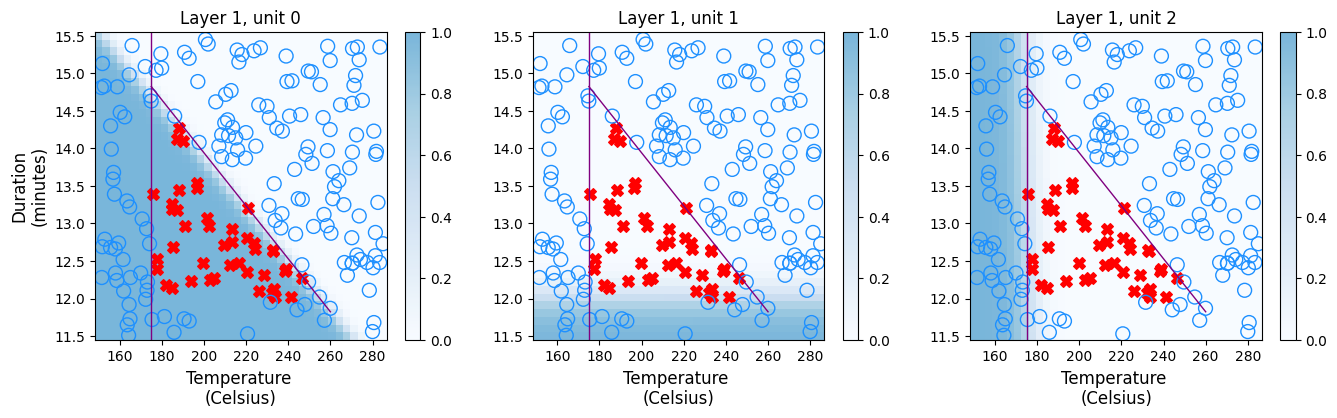

In [41]:
plt_layer(X, Y, W1, b1, norm_layer)

### Visualize Layer 2

The function plot of the final layer is a bit more difficult to visualize. It's inputs are the output of the first layer. We know that the first layer uses sigmoids so their output range is between zero and one. We can create a 3-D plot that calculates the output for all possible combinations of the three inputs. This is shown below.

In [42]:
def plt_output_unit(W, b):
    """plots a single unit function with 3 inputs"""
    steps = 10
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(projection='3d')

    x_ = np.linspace(0.0, 1.0, steps)
    y_ = np.linspace(0.0, 1.0, steps)
    z_ = np.linspace(0.0, 1.0, steps)
    x, y, z = np.meshgrid(x_, y_, z_, indexing='ij')

    d = np.zeros((steps, steps, steps))
    cmap = plt.cm.Blues
    for i in range(steps):
        for j in range(steps):
            for k in range(steps):
                v = np.array([x[i, j, k], y[i, j, k], z[i, j, k]])
                d[i, j, k] = tf.keras.activations.sigmoid(np.dot(v, W.reshape(-1, )) + b).numpy()

    pcm = ax.scatter(x, y, z, c=d, cmap=cmap, alpha=1)
    ax.set_xlabel("unit 0");
    ax.set_ylabel("unit 1");
    ax.set_zlabel("unit 2");
    ax.view_init(30, -120)
    ax.figure.colorbar(pcm, ax=ax)
    ax.set_title(f"Layer 2, output unit")

    plt.show()

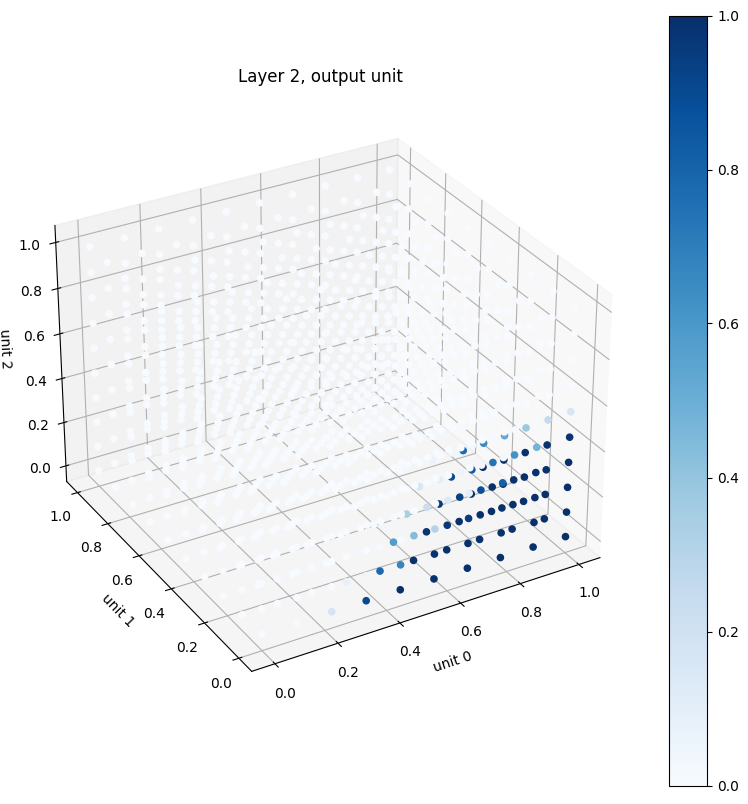

In [43]:
plt_output_unit(W2, b2)

### Network function

The final graph shows the whole network in action.
The left graph is the raw output of the final layer represented by the blue shading. This is overlaid on the training data represented by the X's and O's.
The right graph is the output of the network after a decision threshold. The X's and O's here correspond to decisions made by the network.
The following takes a moment to run

In [44]:
def plt_network(X, Y, netf):
    fig, ax = plt.subplots(1, 2, figsize=(16, 4))

    y = Y.reshape(-1, )
    tr = np.linspace(175, 260, 50)

    # plot prob on left side
    plt_prob(ax[0], netf)

    # plot original data on left side
    ax[0].scatter(X[y==1, 0], X[y==1, 1], s=70, marker='X', c='r', label='Good Roast')
    ax[0].scatter(X[y==0, 0], X[y==0, 1], s=100, marker='o', facecolor='none',
            edgecolors='dodgerblue', linewidth=1, label='Bad Roast')
    ax[0].axhline(y=12, color='purple', linewidth=1)
    ax[0].axvline(x=175, color='purple', linewidth=1)
    ax[0].plot(tr, (-3/85) * tr + 21, color='purple', linewidth=1)
    ax[0].set_xlabel('Temperature\n(Celsius)', size=12)
    ax[0].set_ylabel('Duration\n(minutes)', size=12)
    ax[0].set_title('Network Probability')
    ax[0].legend(loc='upper right')

    predictions = netf(X)
    y_hat = (predictions >= 0.5).astype(int).reshape(-1, )
    ax[1].scatter(X[y_hat==1, 0], X[y_hat==1, 1], s=70, marker='X', c='orange', label='Good Roast')
    ax[1].scatter(X[y_hat==0, 0], X[y_hat==0, 1], s=100, marker='o', facecolor='none',
            edgecolors='dodgerblue', linewidth=1, label='Bad Roast')
    ax[1].axhline(y=12, color='purple', linewidth=1)
    ax[1].axvline(x=175, color='purple', linewidth=1)
    ax[1].plot(tr, (-3/85) * tr + 21, color='purple', linewidth=1)
    ax[1].set_xlabel('Temperature\n(Celsius)', size=12)
    ax[1].set_ylabel('Duration\n(minutes)', size=12)
    ax[1].set_title('Network Decision')
    ax[1].legend(loc='upper right')



    plt.show()

In [45]:
netf = lambda x: model.predict(norm_layer(x), verbose=0)
netf(X_test)

array([[9.7811341e-01],
       [1.0142391e-04]], dtype=float32)

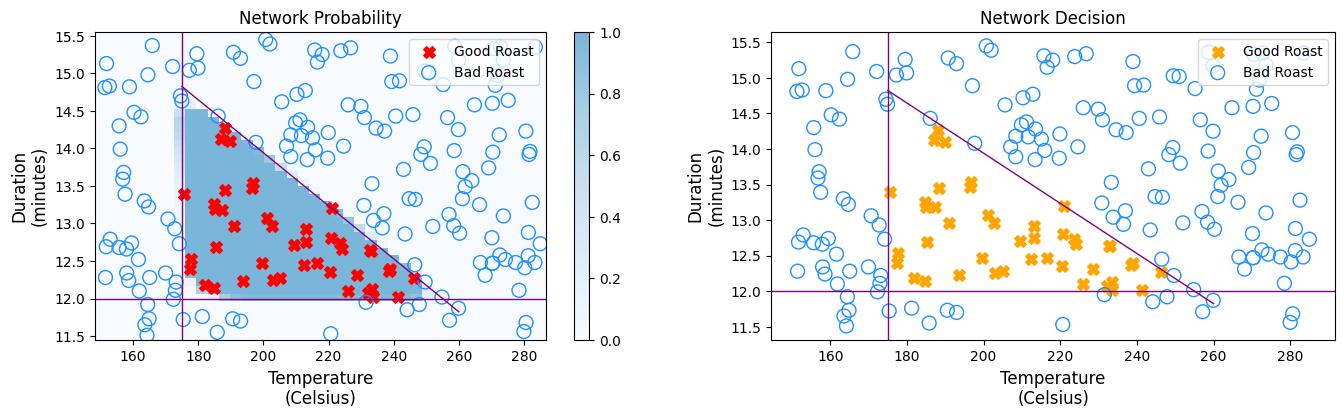

In [46]:
plt_network(X, Y, netf)